# texture-diffusion
using my local huggingface env

https://huggingface.co/dream-textures/texture-diffusion

In [1]:
from diffusers import StableDiffusionPipeline
import torch
from IPython.display import Image

model_id = "dream-textures/texture-diffusion"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "pbr brick wall"
image = pipe(prompt).images[0]  
    
image.save("bricks.png")


model_index.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

c:\Users\willi\miniconda3\envs\huggingface\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\willi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
text_encoder\model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

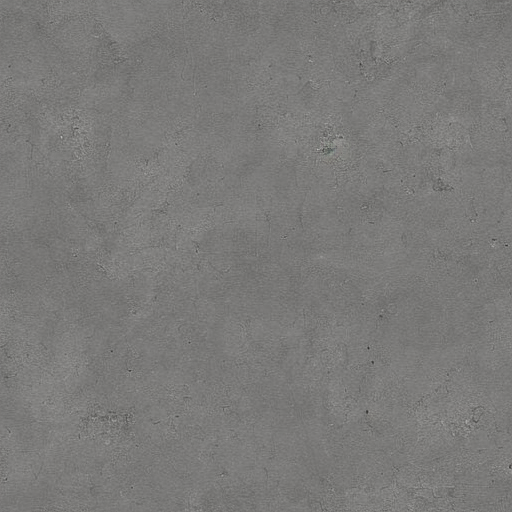

In [6]:
def make_image(prompt,path="default.png"):
    image = pipe(prompt).images[0] 
    image.save(path)
    return image

prompt = "concrete slab smooth. game texture surface"
image = make_image(prompt)
Image(filename="default.png")

